## 1. Chargement des librairies

In [2]:
%matplotlib inline
%run utility.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, LeakyReLU, Dropout, Reshape, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

import os
import random
from tqdm import tqdm

import matplotlib.gridspec as gridspec

tf.keras.backend.clear_session()

## 2. Initialisation de variables globales et constantes

In [3]:
RESIZED_PATH = 'images/resized/'
IMAGES_PATH = 'images/'
RESIZE_VALUE = (256, 256)
INITIAL_DATASET = 'clouds_0_large.csv'
ENRICHED_DATASET = 'clouds_1_large.csv'
ORIGINAL_IMAGE_WIDTH = 2100
ORIGINAL_IMAGE_HEIGHT = 1400
OUTPUT_SHAPE = (8, 8)
BATCH_SIZE = 64
EPOCH = 20
NB_CLASSES = 4
EFFICIENT_NET_INPUT_SHAPE = (256, 256, 3)
LEARNING_RATE = 1e-3
TRAIN_SPLIT_SIZE = 0.7
HIST_FILE = 'training_history.csv'
MODEL_FILE = 'model.h5'
NB_IMAGES_VISU = 4
NB_COLUMN_VISU = 2

## 3. (Optional) Original images are resized

In [ ]:
#resizeImagesFromFolder(IMAGES_PATH, RESIZED_PATH, RESIZE_VALUE)

## 4. Chargement du jeu de données

In [8]:
df = pd.read_csv(INITIAL_DATASET)

df.head(10)

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
6,002be4f.jpg_Gravel,NaN
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...


In [ ]:
df.info()

## 5. Enrichissement du jeu de données

#### Enrichissement

In [4]:
tqdm.pandas(desc="Processing")

df = df.fillna(-1)

# Labéllisation des images
df['Label'] = df['Image_Label'].progress_apply(lambda label: label.split('_')[1])

df['FileName'] = df['Image_Label'].progress_apply(lambda label: label.split('_')[0])

# Comptage des pixels d'un segment (taille d'origine)
df['EncodedPixels_array'] = df['EncodedPixels'].progress_apply(lambda x: convertEndocedToArray(x))
df['EncodedPixelsCount'] = df['EncodedPixels_array'].progress_apply(lambda x: countEncodedPixels(x))

# # Ajout de la Bounding Box (taille réduite)
df = buildBoundingBox(df, RESIZE_VALUE)

# # Esimation de l'étendue des bandes noires
df['result'] = df['Image_Label'].progress_apply(lambda x: getBlackStripesOverlapInfo(x, IMAGES_PATH, df, ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT))
df['segmentCroppingRate'] = df['result'].progress_apply(lambda x: x[6])

# # Suppression des colonnes temporaires
df = df.drop(labels=['result'], axis=1)
df = df.drop(labels=['EncodedPixels_array'], axis=1)

df.head(10)

Processing: 100%|██████████| 22184/22184 [00:00<00:00, 1939154.28it/s]


,Image_Label,EncodedPixels,Label,FileName,EncodedPixelsCount,XMOY,YMOY,W,H,ResizedMaskPixelsCount,ResizedBoundingBoxPixelsCount,BoxMaskGap,segmentCroppingRate
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg,932312,83.5,143.5,121,171,20690,20691,0.000048,1.000000
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg,1156107,186.5,153.5,137,193,25770,26441,0.026038,0.611588
2,0011165.jpg_Gravel,-1,Gravel,0011165.jpg,0,0.0,0.0,0,0,0,0,0.000000,0.000000
3,0011165.jpg_Sugar,-1,Sugar,0011165.jpg,0,0.0,0.0,0,0,0,0,0.000000,0.000000
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg,1684325,137.0,82.5,234,161,37554,37674,0.003195,0.000000
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,Flower,002be4f.jpg,592697,186.0,208.0,140,96,13066,13440,0.028624,0.000000
6,002be4f.jpg_Gravel,-1,Gravel,002be4f.jpg,0,0.0,0.0,0,0,0,0,0.000000,0.000000
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,Sugar,002be4f.jpg,313950,60.5,86.0,109,64,6976,6976,0.000000,0.000000
8,0031ae9.jpg_Fish,3510 690 4910 690 6310 690 7710 690 9110 690 1...,Fish,0031ae9.jpg,1240822,111.0,193.0,222,126,27643,27972,0.011902,0.000000
9,0031ae9.jpg_Flower,2047 703 3447 703 4847 703 6247 703 7647 703 9...,Flower,0031ae9.jpg,1178858,90.5,169.0,181,156,26287,28236,0.074143,0.000000


#### Normalisation

In [5]:
df['xmoy'] = df['XMOY'] / RESIZE_VALUE[1]
df['ymoy'] = df['YMOY'] / RESIZE_VALUE[0]
df['w'] = df['W'] / RESIZE_VALUE[1]
df['h'] = df['H'] / RESIZE_VALUE[0]

df = df.reindex(columns=['Image_Label', 'FileName', 'EncodedPixels', 'EncodedPixelsCount', 'segmentCroppingRate' ,'XMOY', 'YMOY', 'W', 'H', 'ResizedMaskPixelsCount', 'ResizedBoundingBoxPixelsCount', 'BoxMaskGap', 'Label', 'xmoy', 'ymoy', 'w', 'h'])
df = df.join(pd.get_dummies(df['Label'], prefix='Class').astype(int))

df.head(10)

,Image_Label,FileName,EncodedPixels,EncodedPixelsCount,segmentCroppingRate,XMOY,YMOY,W,H,ResizedMaskPixelsCount,...,BoxMaskGap,Label,xmoy,ymoy,w,h,Class_Fish,Class_Flower,Class_Gravel,Class_Sugar
0,0011165.jpg_Fish,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,932312,1.000000,83.5,143.5,121,171,20690,...,0.000048,Fish,0.326172,0.560547,0.472656,0.667969,1,0,0,0
1,0011165.jpg_Flower,0011165.jpg,1355565 1002 1356965 1002 1358365 1002 1359765...,1156107,0.611588,186.5,153.5,137,193,25770,...,0.026038,Flower,0.728516,0.599609,0.535156,0.753906,0,1,0,0
2,0011165.jpg_Gravel,0011165.jpg,-1,0,0.000000,0.0,0.0,0,0,0,...,0.000000,Gravel,0.000000,0.000000,0.000000,0.000000,0,0,1,0
3,0011165.jpg_Sugar,0011165.jpg,-1,0,0.000000,0.0,0.0,0,0,0,...,0.000000,Sugar,0.000000,0.000000,0.000000,0.000000,0,0,0,1
4,002be4f.jpg_Fish,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1684325,0.000000,137.0,82.5,234,161,37554,...,0.003195,Fish,0.535156,0.322266,0.914062,0.628906,1,0,0,0
5,002be4f.jpg_Flower,002be4f.jpg,1339279 519 1340679 519 1342079 519 1343479 51...,592697,0.000000,186.0,208.0,140,96,13066,...,0.028624,Flower,0.726562,0.812500,0.546875,0.375000,0,1,0,0
6,002be4f.jpg_Gravel,002be4f.jpg,-1,0,0.000000,0.0,0.0,0,0,0,...,0.000000,Gravel,0.000000,0.000000,0.000000,0.000000,0,0,1,0
7,002be4f.jpg_Sugar,002be4f.jpg,67495 350 68895 350 70295 350 71695 350 73095 ...,313950,0.000000,60.5,86.0,109,64,6976,...,0.000000,Sugar,0.236328,0.335938,0.425781,0.250000,0,0,0,1
8,0031ae9.jpg_Fish,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,1240822,0.000000,111.0,193.0,222,126,27643,...,0.011902,Fish,0.433594,0.753906,0.867188,0.492188,1,0,0,0
9,0031ae9.jpg_Flower,0031ae9.jpg,2047 703 3447 703 4847 703 6247 703 7647 703 9...,1178858,0.000000,90.5,169.0,181,156,26287,...,0.074143,Flower,0.353516,0.660156,0.707031,0.609375,0,1,0,0


#### (Optional) Enregistrement du Dataset enrichi

In [6]:
if not(os.path.exists(ENRICHED_DATASET)):
    df.to_csv(ENRICHED_DATASET, index=False)

## 6. Filtrage des images altérées

#### (Optional) Pointage des observations non masquées de façon significative par une barre noire (moins de 10% de l'image)

In [ ]:
# df = df[df['segmentCroppingRate'] <= 0.1]
# df.info()

#### (Optional) Pointage des observations décrites par des segments non-disjoints (Ecart en segment et bbox < 9.%)

In [ ]:
# GAP_LIMIT_LOW = 0
# GAP_LIMIT_HIGH = 0.09 # 9.0%

# df = df[(df['BoxMaskGap'] >= GAP_LIMIT_LOW) & (df['BoxMaskGap'] < GAP_LIMIT_HIGH)].sort_values(by='BoxMaskGap', ascending=False)
# df.info()

## 6. Séparation du jeu de données

#### Extraction d'un échantillon d'observations mono class

In [7]:
# On retire 100 images mono-class du jeu d'entraînement et de test que le système ne voit pas durant l'entraînement
tmp = df[df['EncodedPixels'] != -1]
value_counts = tmp['FileName'].value_counts()
mono_class_items = tmp[tmp['FileName'].map(value_counts) == 1].head(100).FileName.tolist()
df_mono_class_unseen = tmp[tmp['FileName'].isin(mono_class_items)]
df_mono_class_unseen.reset_index(drop=True, inplace=True)

df_train_test = df[~df['FileName'].isin(mono_class_items)]

#### Séparation du jeu de données (entaînement et test)

In [8]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_train_test.FileName.values, df_train_test.iloc[:, -8:].values, train_size=TRAIN_SPLIT_SIZE, random_state=42)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.shuffle(100000).map(lambda x, y : tf.py_function(load_image, [x, y], [tf.float32, tf.float32]), num_parallel_calls=-1).batch(int(BATCH_SIZE))

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
dataset_test = dataset_test.map(lambda x, y : tf.py_function(load_image, [x, y], [tf.float32, tf.float32]), num_parallel_calls=-1).batch(int(BATCH_SIZE))

#### (Optional) Test du Dataset

2024-03-13 01:02:24.934856: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


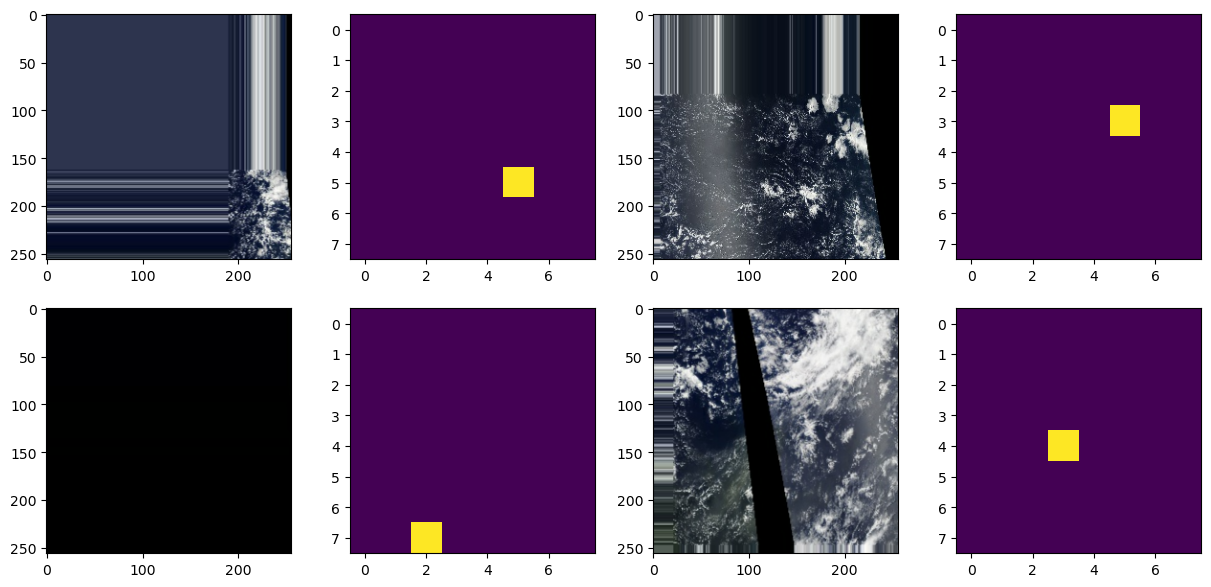

In [9]:
X_t, y_t = next(iter(dataset_train))
plt.figure(figsize=(15,7))
for j, i in enumerate(np.random.randint(0, BATCH_SIZE, 4)):
    plt.subplot(2,4,2*j+1)
    plt.imshow(X_t[i].numpy().astype(int))
    plt.subplot(2,4,2*j+2)
    plt.imshow(y_t[i,:,0].numpy().reshape(OUTPUT_SHAPE))

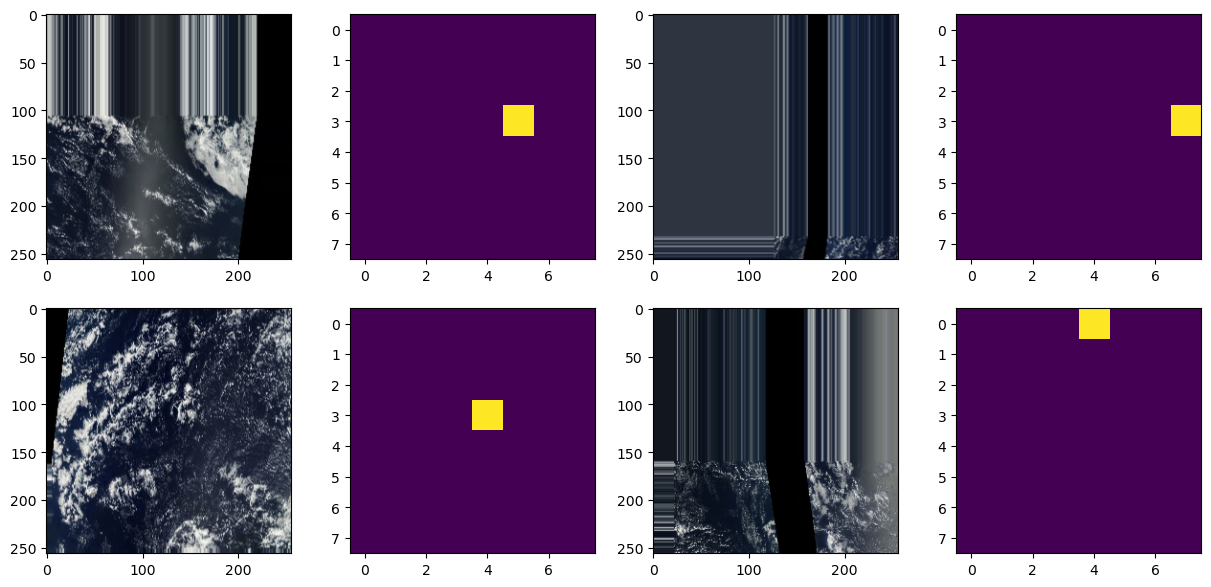

In [10]:
X_t, y_t = next(iter(dataset_test))
plt.figure(figsize=(15,7))
for j, i in enumerate(np.random.randint(0, BATCH_SIZE, [4])):
    plt.subplot(2,4,2*j+1)
    plt.imshow(X_t[i].numpy().astype(int))
    plt.subplot(2,4,2*j+2)
    plt.imshow(y_t[i,:,0].numpy().reshape(OUTPUT_SHAPE))

## 7. Définition du modèle

In [5]:
# Backbone
efficientNet = EfficientNetB0(include_top=False, input_shape=EFFICIENT_NET_INPUT_SHAPE, weights="imagenet")

# Freeze the blackbone
for layer in efficientNet.layers:
    layer.trainable = False

model = Sequential()

# Feature extraction
model.add(efficientNet) 
model.add(Reshape([-1, 1280]))

# Regression
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5 + NB_CLASSES))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 reshape (Reshape)           (None, 64, 1280)          0         
                                                                 
 dense (Dense)               (None, 64, 1024)          1311744   
                                                                 
 dropout (Dropout)           (None, 64, 1024)          0         
                                                                 
 dense_1 (Dense)             (None, 64, 512)           524800    
                                                                 
 dropout_1 (Dropout)         (None, 64, 512)           0         
                                                                 
 dense_2 (Dense)             (None, 64, 256)           1

## 8. Entraînement du modèle

In [12]:
model.compile(
    optimizer=Adam(LEARNING_RATE), 
    loss=global_loss, 
    metrics=mean_iou
)

# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'auto_saved_model.h5', monitor = 'loss', save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 'epoch')

# Callback to reduce automatically the learning rate.
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss', patience=5, factor=0.1, verbose=2, mode='min')

hist = model.fit(dataset_train, epochs=EPOCH, validation_data=dataset_test, workers=-1, callbacks=[lr_plateau, checkpoint])

model.save('model.h5')

Epoch 1/20


2024-03-13 01:02:55.426385: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'global_loss/cond/output/_10'
2024-03-13 01:02:55.436217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 6.6603 - mean_iou: 2.2672e-04

2024-03-13 01:04:01.603849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 97s 394ms/step - loss: 6.6603 - mean_iou: 2.2672e-04 - val_loss: 5.6688 - val_mean_iou: 2.5134e-04 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 94s 392ms/step - loss: 5.6966 - mean_iou: 2.7460e-04 - val_loss: 5.5357 - val_mean_iou: 2.7016e-04 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 92s 386ms/step - loss: 5.5444 - mean_iou: 2.8739e-04 - val_loss: 5.3996 - val_mean_iou: 2.7222e-04 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 93s 389ms/step - loss: 5.4668 - mean_iou: 3.0631e-04 - val_loss: 5.3231 - val_mean_iou: 2.7780e-04 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 93s 387ms/step - loss: 5.3084 - mean_iou: 3.2502e-04 - val_loss: 5.3768 - val_mean_iou: 2.4069e-04 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 94s 392ms/step - loss: 5.2437 - mean_iou: 3.3919e-04 - val_loss: 5.2128 - val_mean_iou: 3.1363e-04 - lr: 0.0010
Epoch 7/20
239/

#### (Optional) Sauvegarde de l'historique d'apprentissage

In [13]:
# Enregistrement du dataset hist
if not(os.path.exists(HIST_FILE)):
    hist_df = pd.DataFrame(hist.history)
    hist_df.to_csv(HIST_FILE, index=False)

#### Affichage de l'historique d'apprentissage

In [14]:
# Chargement du dataset hist
if (hist == None):
    if os.path.exists(HIST_FILE):
        hist = pd.read_csv(HIST_FILE)    
else:
    hist = hist.history

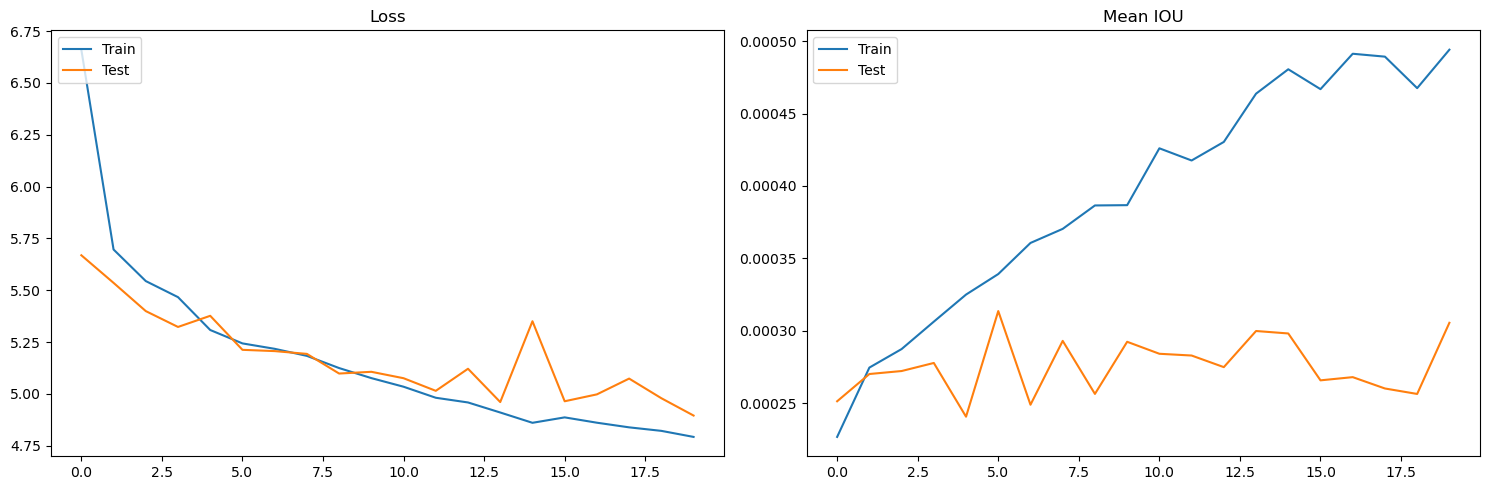

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

axes[0].set_title('Loss')
axes[0].plot(hist['loss'])
axes[0].plot(hist['val_loss'])
axes[0].legend(['Train', 'Test'], loc='upper left')

axes[1].set_title('Mean IOU')
axes[1].plot(hist['mean_iou'])
axes[1].plot(hist['val_mean_iou'])
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

## 8. Prédiction

#### (Optional) Prédiction et affichage des résultats

In [6]:
# Chargement du modèle depuis la sauvegrade model.h5
if (model == None):
    if os.path.exists(MODEL_FILE):
        model = tf.keras.models.load_model(MODEL_FILE, custom_objects={'global_loss': global_loss, 'mean_iou': mean_iou})

#### ATTENTION : Choisir le bon échantillon à visualiser

In [23]:
# Création d'une liste de 100 images mono-class vu par le système pendant l'apprentissage
tmp = df_train_test[df_train_test['EncodedPixels'] != -1]
value_counts = tmp['FileName'].value_counts()
mono_class_items_seen = tmp[tmp['FileName'].map(value_counts) == 1].head(100).FileName.tolist()
df_mono_class_seen = tmp[tmp['FileName'].isin(mono_class_items_seen)]
df_mono_class_seen.reset_index(drop=True, inplace=True)

# UNSEEN #

# Liste de 100 images mono classe jamais vu par le modèle toute classe confondue
#sample_for_visu = df_mono_class_unseen

# Liste de 100 images mono classe vu par le modèle filtré par classe
sample_for_visu = df_mono_class_unseen[df_mono_class_unseen['Label'] == 'Fish']

# SEEN

# Liste de 100 images mono classe vu par le modèle toute classe confondue
#sample_for_visu = df_mono_class_seen

# Liste de 100 images mono classe vu par le modèle filtré par classe
#sample_for_visu = df_mono_class_seen[df_mono_class_seen['Label'] == 'Flower']

#### Visualisation des échantillons par lots de 4


Liste des images: ['0146ef3.jpg_Fish', '10ed865.jpg_Fish', '0d90683.jpg_Fish', '01eecc1.jpg_Fish']



100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


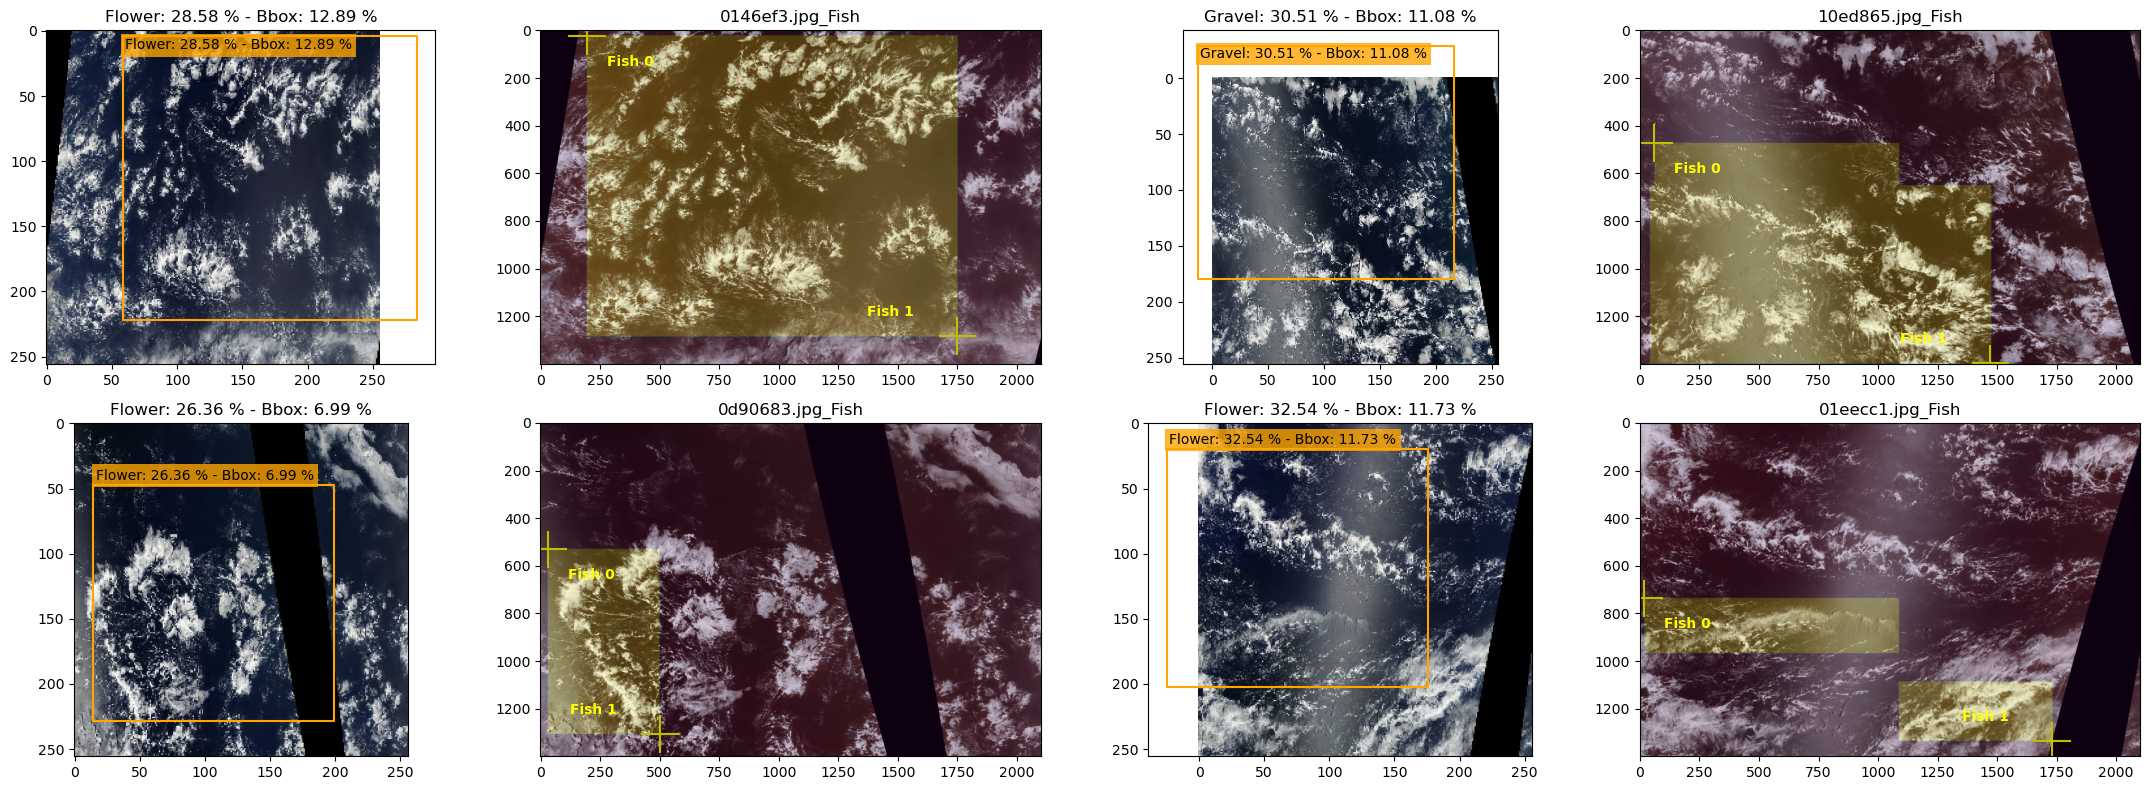

array([[0.11728794, 0.29461306, 0.43240127, 0.783388  , 0.71288824,
        0.29619944, 0.3254244 , 0.19471297, 0.18366313]], dtype=float32)

In [25]:
axes = []
FileNames = []
Image_Labels = []

for i, id in enumerate(np.random.randint(0, len(sample_for_visu), NB_IMAGES_VISU)):
    FileNames.append(sample_for_visu.iloc[id, :2].FileName)
    Image_Labels.append(sample_for_visu.iloc[id, :2].Image_Label)

print("\nListe des images:", str(Image_Labels) + "\n")

gs = gridspec.GridSpec(nrows=int(NB_IMAGES_VISU/NB_COLUMN_VISU), ncols=(NB_COLUMN_VISU * 2))
fig = plt.figure(figsize=(22,8))

for row in range(int(NB_IMAGES_VISU/NB_COLUMN_VISU)):
    for col in range(NB_COLUMN_VISU * 2): # 2 images per columns
        axes.append(plt.subplot(gs[row, col]))

for i in tqdm(range(NB_IMAGES_VISU)):
    img = tf.io.read_file(RESIZED_PATH + FileNames[i])
    img = tf.image.decode_png(img, channels=3)
    result = show_prediction(img , model, axes[2 * i], threshold=0.6)
    show_ground(Image_Labels[i], axes[2 * i + 1], df, ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT, IMAGES_PATH, hide_axis=False, show_mask=True)

plt.tight_layout()
plt.show()
result

#### Tests unitaires (n'importe quel type d'échantillon)

In [ ]:
%run utility.ipynb
fName = '100752c.jpg'
imLabel = '100752c.jpg_Gravel'
img = tf.io.read_file(RESIZED_PATH + fName)
img = tf.image.decode_png(img, channels=3)

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
result = show_prediction(img , model, axes[0], threshold=0.6)
show_ground(imLabel, axes[1], df, ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT, IMAGES_PATH, hide_axis=False, show_mask=True)
            
plt.tight_layout()
plt.show()
print(result)